<a href="https://colab.research.google.com/github/gitHubAndyLee2020/Celeb_Face_Generator/blob/main/celeb_face_generator_bw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Gray-Scale
- 10k Images
- 176x176 (original dimension: 178x228)
- Trained for 750 epochs in total

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-cu94ukej
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-cu94ukej
  Resolved https://github.com/tensorflow/docs to commit 2b700605aaf42a346624aaff5c84879999d4c407
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.9.4.19335-py3-none-any.whl size=184104 sha256=7e1943d167610bca65720c6713a3b51e665611f58379744a697ace65ae0c453f
  Stored in directory: /tmp/pip-ephem-wheel-cache-00gejwn6/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving selected_images_10k.zip to selected_images_10k.zip
User uploaded file "selected_images_10k.zip" with length 69933417 bytes


In [6]:
! unzip selected_images_10k.zip

Streaming output truncated to the last 5000 lines.
  inflating: selected_images/005001.jpg  
  inflating: selected_images/005002.jpg  
  inflating: selected_images/005003.jpg  
  inflating: selected_images/005004.jpg  
  inflating: selected_images/005005.jpg  
  inflating: selected_images/005006.jpg  
  inflating: selected_images/005007.jpg  
  inflating: selected_images/005008.jpg  
  inflating: selected_images/005009.jpg  
  inflating: selected_images/005010.jpg  
  inflating: selected_images/005011.jpg  
  inflating: selected_images/005012.jpg  
  inflating: selected_images/005013.jpg  
  inflating: selected_images/005014.jpg  
  inflating: selected_images/005015.jpg  
  inflating: selected_images/005016.jpg  
  inflating: selected_images/005017.jpg  
  inflating: selected_images/005018.jpg  
  inflating: selected_images/005019.jpg  
  inflating: selected_images/005020.jpg  
  inflating: selected_images/005021.jpg  
  inflating: selected_images/005022.jpg  
  inflating: selected_ima

In [65]:
import tensorflow as tf
import numpy as np
import os
import random
from PIL import Image

# Step 1: List all image files
folder_path = 'selected_images'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Step 2: Randomly select 5 images
selected_images = random.sample(image_files, 5)

# Step 3: Load images into a NumPy array
image_list = []
image_shapes = []
for image_file in selected_images:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((176, 176))
    image_array = np.array(image)
    image_shapes.append(image_array.shape)
    image_list.append(image_array)

images_np = np.array(image_list)

# Step 4: Preprocess images
images_np = images_np.reshape(images_np.shape[0], 176, 176, 1).astype('float32')
images_np = (images_np - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Step 5: Create tf.data.Dataset object
BUFFER_SIZE = 5  # Since we only have 5 images
BATCH_SIZE = 1   # We can only have batch size of 1 or 5 in this example

train_dataset = tf.data.Dataset.from_tensor_slices(images_np).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

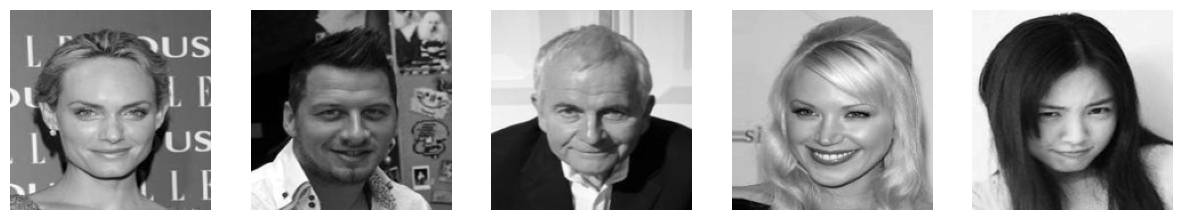

In [66]:
import matplotlib.pyplot as plt

# Reverse normalization for display
display_images = (images_np + 1) * 127.5
display_images = np.squeeze(display_images, axis=-1)  # Remove the last dimension to make it 2D

# Display the 5 selected images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(display_images[i], cmap='gray')
    ax.axis('off')

plt.show()

In [71]:
import tensorflow as tf
import numpy as np
import os
import random
from PIL import Image

# Step 1: List all image files
folder_path = 'selected_images'
image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Step 2: Load images into a NumPy array
image_list = []
image_shapes = []
for image_file in selected_images:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((176, 176))
    image_array = np.array(image)
    image_shapes.append(image_array.shape)
    image_list.append(image_array)

images_np = np.array(image_list)

# Step 3: Preprocess images
height, width = image_shapes[0]
images_np = images_np.reshape(images_np.shape[0], 176, 176, 1).astype('float32')
images_np = (images_np - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Step 4: Create tf.data.Dataset object
BUFFER_SIZE = len(image_files)  # Since we only have 5 images
BATCH_SIZE = 256   # We can only have batch size of 1 or 5 in this example

train_dataset = tf.data.Dataset.from_tensor_slices(images_np).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [69]:
import tensorflow as tf

def make_generator_model():
    model = tf.keras.Sequential()
    layers = tf.keras.layers  # Shorthand to make the code cleaner

    # Initial dense layer
    model.add(layers.Dense(11*11*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Reshape layer
    model.add(layers.Reshape((11, 11, 512)))
    assert model.output_shape == (None, 11, 11, 512)

    # Transposed convolution layers
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 22, 22, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 44, 44, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 88, 88, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 176, 176, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 176, 176, 1)  # Final output shape

    return model

# Test the function
make_generator_model().summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 61952)             6195200   
                                                                 
 batch_normalization_46 (Bat  (None, 61952)            247808    
 chNormalization)                                                
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 61952)             0         
                                                                 
 reshape_10 (Reshape)        (None, 11, 11, 512)       0         
                                                                 
 conv2d_transpose_45 (Conv2D  (None, 22, 22, 256)      3276800   
 Transpose)                                                      
                                                                 
 batch_normalization_47 (Bat  (None, 22, 22, 256)    

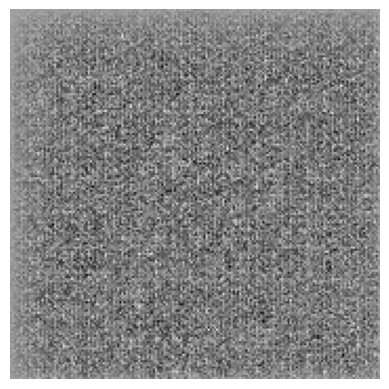

In [72]:
# Create the generator model with the new architecture
generator = make_generator_model()

# Generate random noise as input for the generator
noise = tf.random.normal([1, 100])

# Generate an image
generated_image = generator(noise, training=False)

# Show the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [56]:
def prime_factors(n):
    i = 2
    factors = []
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.append(i)
    if n > 1:
        factors.append(n)
    return factors

# Test the function
print(prime_factors(178))
print(prime_factors(218))
print(prime_factors(176))
print(prime_factors(224))

[2, 89]
[2, 109]
[2, 2, 2, 2, 11]
[2, 2, 2, 2, 2, 7]


In [73]:
import tensorflow as tf

def make_discriminator_model():
    model = tf.keras.Sequential()
    layers = tf.keras.layers  # Shorthand for tf.keras.layers

    # First Conv2D Layer: Input shape [176, 176, 1]
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[176, 176, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second Conv2D Layer: Intermediate shape becomes [88, 88, 64]
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third Conv2D Layer: Intermediate shape becomes [44, 44, 128]
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Fourth Conv2D Layer: Intermediate shape becomes [22, 22, 256]
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Flatten Layer: Flatten the 3D tensor into 1D tensor
    model.add(layers.Flatten())

    # Output Layer: Produces a single output for real/fake classification
    model.add(layers.Dense(1))

    return model

# Test the function
make_discriminator_model().summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 88, 64)        1664      
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 88, 88, 64)        0         
                                                                 
 dropout (Dropout)           (None, 88, 88, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 128)       204928    
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 44, 44, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 44, 44, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 256)     

In [78]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00013386]], shape=(1, 1), dtype=float32)


In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [80]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [81]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [83]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [84]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [102]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [86]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [87]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:05d}.png'.format(epoch))
  plt.show()

In [88]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

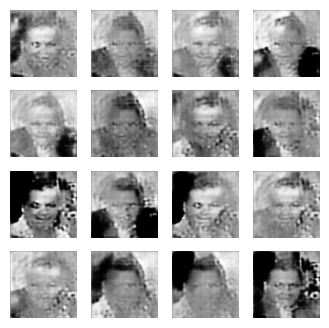

Time for epoch 250 is 14.262764692306519 sec


KeyboardInterrupt: ignored

In [103]:
train(train_dataset, EPOCHS)

In [104]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [98]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:05d}.png'.format(epoch_no + 500))

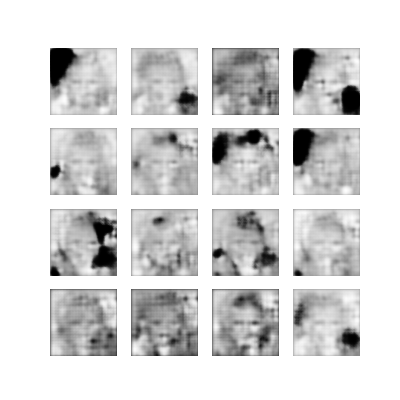

In [99]:
display_image(EPOCHS)

In [100]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-100-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-100-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [114]:
import imageio
from glob import glob

anim_file = 'dcgan.gif'

# Get all filenames matching the pattern
filenames = glob('image_at_epoch_*.png')

# Sort filenames
filenames = sorted(filenames)

# Filter filenames to include only those up to epoch 250
filtered_filenames = []
for filename in filenames:
    epoch_number = int(filename.split('_')[-1].split('.')[0])
    if 1 <= epoch_number <= 250:
        filtered_filenames.append(filename)

# Create GIF
with imageio.get_writer(anim_file, mode='I') as writer:
    for filename in filtered_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image again to maintain the loop in the GIF
    if filtered_filenames:
        image = imageio.imread(filtered_filenames[-1])
        writer.append_data(image)

<ipython-input-114-6903c3ae27d2>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-114-6903c3ae27d2>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filtered_filenames[-1])



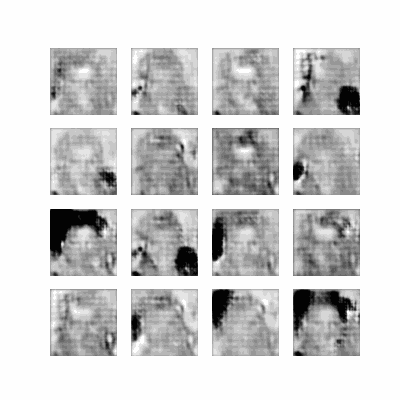

In [115]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

- Conclusion: higher resolution and more data improves image clarity and sharpness, but not significantly.